# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [5]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from collections import defaultdict
import sys

In [6]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

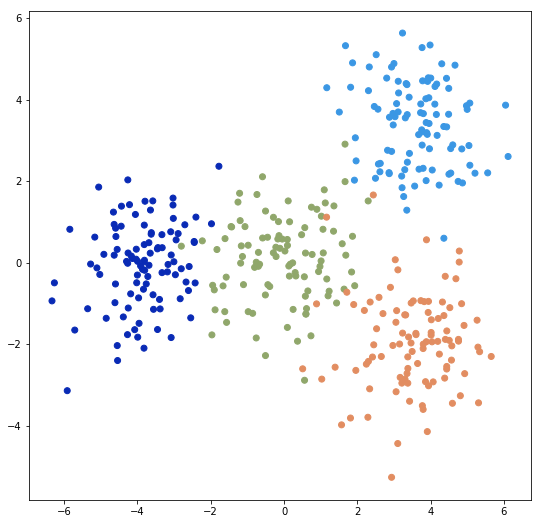

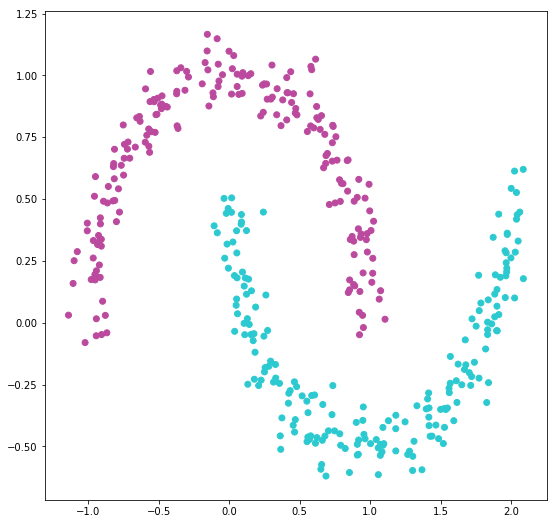

In [7]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [8]:
class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=300):
        self.k = n_clusters
        self.max_iter = max_iter
        if init == "random":
            self.get_centroids = self.random_centroids
        elif init == "sample":
            self.get_centroids = self.sample_centroids
        elif init == "k-means++":
            self.get_centroids = self.k_means_plus_plus
        else:
            raise ValueError(f"Wrong init {init}")
    
    def random_centroids(self, X, num):
        maxs = np.max(X, axis=0)
        mins = np.min(X, axis=0) 
        cntrs = np.random.rand(num, X.shape[1]) * (maxs - mins) + mins
        return cntrs
    
    def sample_centroids(self, X, num):
        cntrs = X[np.random.choice(X.shape[0], num, replace=False)]
        return cntrs
    
    def k_means_plus_plus(self, X, num):
        cntrs = X[np.random.choice(X.shape[0], 1)]
        for i in range(num - 1):
            dists = np.apply_along_axis(lambda v: np.linalg.norm(v-cntrs, axis=1), 1, X)
            pr = np.min(dists, axis=1)**2
            pr = np.cumsum(pr)
            pr = pr / pr[-1]
            new_ind = np.searchsorted(pr, np.random.rand())
            cntrs = np.vstack((cntrs, X[new_ind]))
        return cntrs
        
    def fit(self, X, y=None):
        cntrs = self.get_centroids(X, self.k)
        cnt = 0
        
        def recount_centroid(j):
            am = np.sum(ind==j)
            if am == 0:
                res = self.get_centroids(X, 1)
            else:
                res = np.sum(X[ind==j], axis=0)/ am
            if not np.array_equal(res, cntrs[j]):
                flag = True
            return res
        
        flag = True
        while cnt < self.max_iter and flag:
            cnt += 1
            dists = np.apply_along_axis(lambda v: np.linalg.norm(v-cntrs, axis=1), 1, X)
            ind = np.argmin(dists, axis=1)
            flag = False
            cntrs = np.apply_along_axis(recount_centroid, 1, np.arange(self.k).reshape(self.k, 1))
        self.centroids = cntrs
    
    def predict(self, X):
        dists = np.apply_along_axis(lambda v: np.linalg.norm(v-self.centroids, axis=1), 1, X)
        ind = np.argmin(dists, axis=1)
        return ind

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

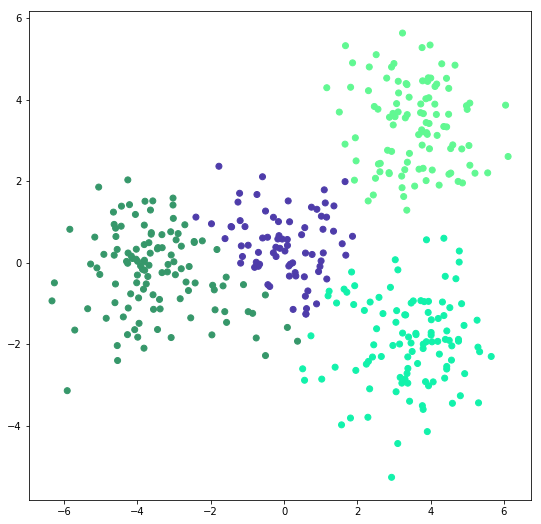

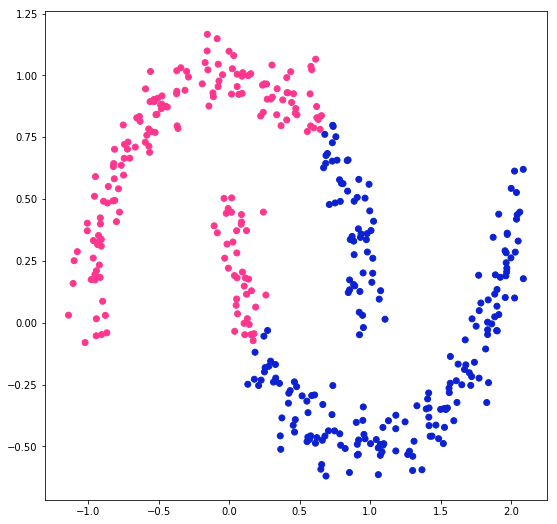

In [9]:
kmeans = KMeans(n_clusters=4, init="k-means++")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init="k-means++")
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [8]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.k = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
    
    def fit_predict(self, X, y=None):
        kdtree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        Y = kdtree.query_radius(X, self.eps)
        cur = 0
        ans = -np.ones(len(X)).astype(int)
        def dfs(i):
            if ans[i] == -1:
                ans[i] = cur
            for j in Y[i]:
                if ans[j] == -1:
                    ans[j] = cur
                    if Y[j].shape[0] > self.k:
                        dfs(j)

        for i in range(len(X)):
            if ans[i] == -1 and Y[i].shape[0] > self.k:
                dfs(i)
                cur += 1
#         ans[ans==-1] = None 
        return ans

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

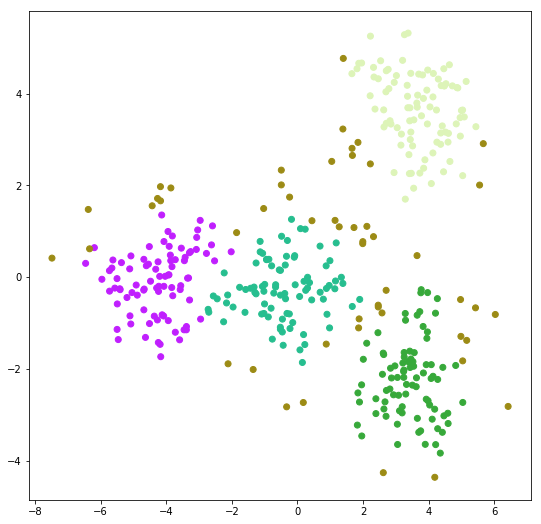

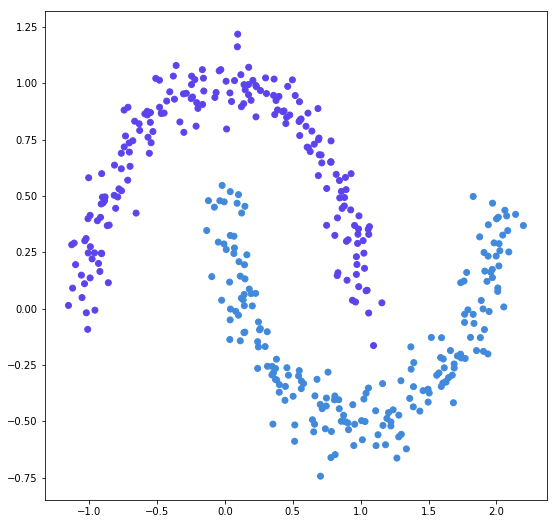

In [15]:
dbscan = DBScan(eps=0.7, min_samples=10)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps = 0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [3]:
class AgglomertiveClustering:
    def __init__(self, n_clusters=16, linkage="average"):
        self.k = n_clusters
        if linkage == "average":
            self.dist = self.dist_average
        elif linkage == "single":
            self.dist = self.dist_single
        elif linkage == "complete":
            self.dist = self.dist_complete
        else:
            raise ValueError(f"Wrong linkage - {linkage}")
    
    @staticmethod
    def dist_average(ind1, ind2, X):
        return np.mean(np.apply_along_axis(lambda v: np.linalg.norm(v-X[ind1], axis=1), 1, X[ind2]))

    @staticmethod
    def dist_single(ind1, ind2, X):
        return np.min(np.apply_along_axis(lambda v: np.linalg.norm(v-X[ind1], axis=1), 1, X[ind2]))
    
    @staticmethod
    def dist_complete(ind1, ind2, X):
        return np.max(np.apply_along_axis(lambda v: np.linalg.norm(v-X[ind1], axis=1), 1, X[ind2]))
    
    def fit_predict(self, X, y=None):
        clusters = {i:[i] for i in range(X.shape[0])}
        dist_matrix = {}
        for i in clusters:
            for j in clusters:
                if i < j:
                    dist_matrix[i, j] = self.dist(clusters[i], clusters[j], X)
        while len(clusters) > self.k:
            cl1, cl2 = min(dist_matrix, key=dist_matrix.get)
            clusters[cl1].extend(clusters[cl2])
            del clusters[cl2]
            for cl3 in clusters:
                del dist_matrix[min(cl3, cl2), max(cl3, cl2)]
                if cl3 != cl1:
                    dist_matrix[min(cl3, cl1), max(cl3, cl1)] = self.dist(clusters[cl1], clusters[cl3], X)
        ans = -np.ones(X.shape[0]).astype(int)
        for ind, cl in enumerate(clusters):
            ans[clusters[cl]] = ind
        return ans

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

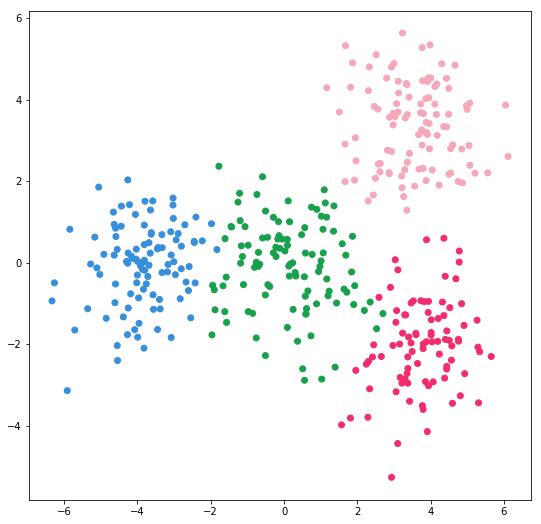

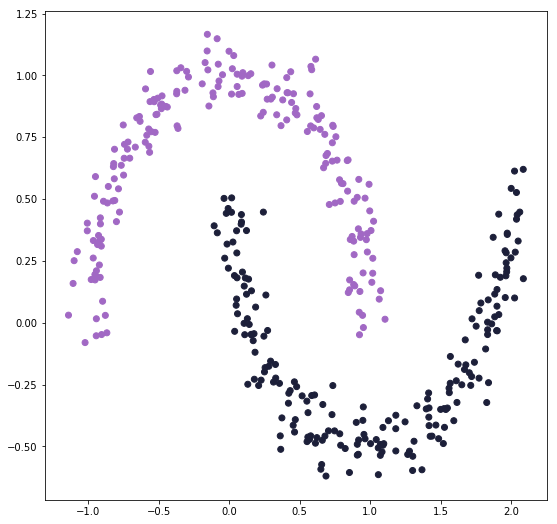

CPU times: user 24.5 s, sys: 779 ms, total: 25.3 s
Wall time: 24.6 s


In [10]:
%%time
agg_clustering = AgglomertiveClustering(n_clusters=4, linkage="complete")
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage="single")
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [20]:
def read_image(path):
    im = cv2.imread(path)
    return im[:,:,::-1]

def show_image(image):
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image, path):
    cv2.imwrite(path, image[:,:,::-1])

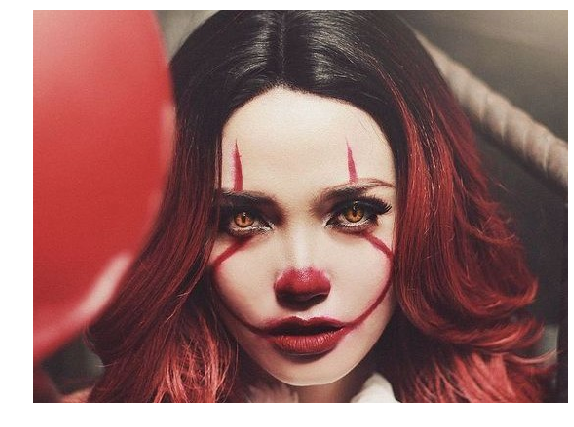

In [13]:
show_image(read_image("./image.png"))

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [18]:
def clusterize_image(image, init="sample", col=8):
    n, m, c = image.shape
    flat_image = image.reshape(n*m, c)
    kmeans = KMeans(n_clusters=col, init=init)
    kmeans.fit(flat_image)
    cluster_colors = kmeans.centroids.astype(int) # color of each cluster
    clusters = kmeans.predict(flat_image) # Cluster labels for each pixel in flattened image
    recolored = cluster_colors[clusters].reshape(n, m, c) # Image with pixel colors assigned to corresponding cluster colors
    
    clusters_statistics(image.reshape(-1, 3)/255, cluster_colors/255, clusters) # Very slow (:
    
    return recolored

**оригинал**

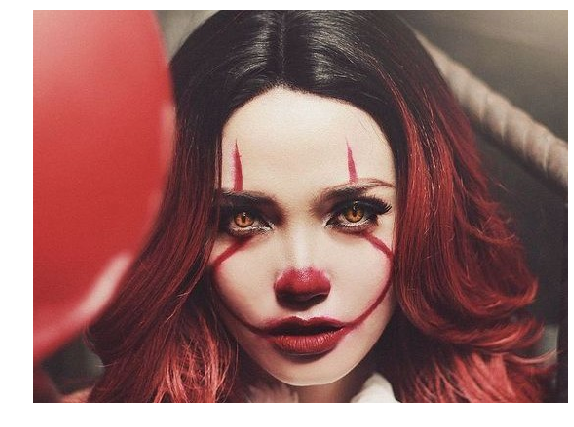

In [16]:
show_image(read_image("./image.png"))

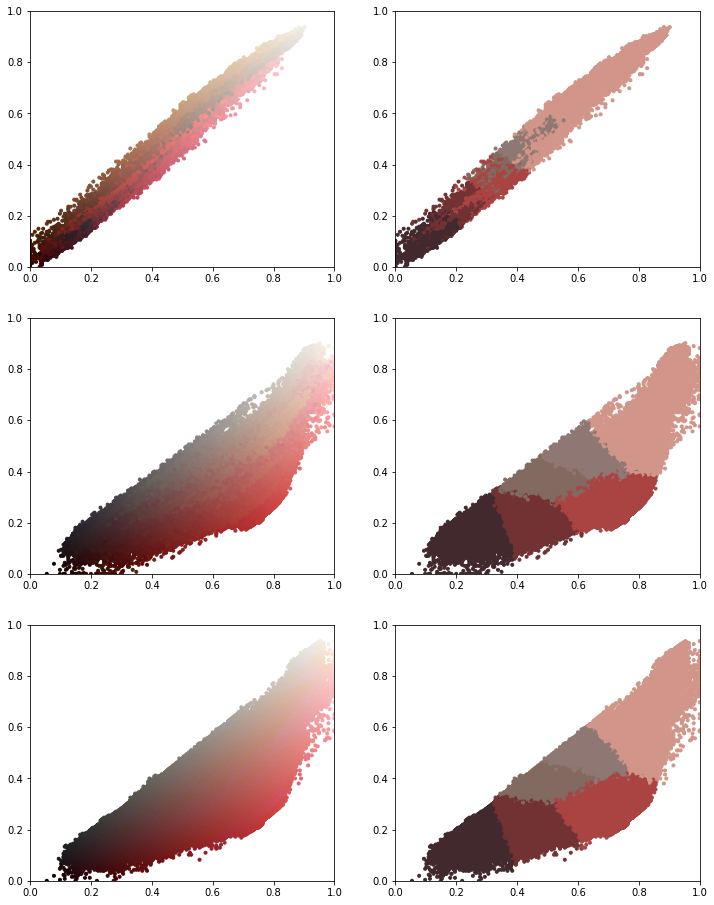

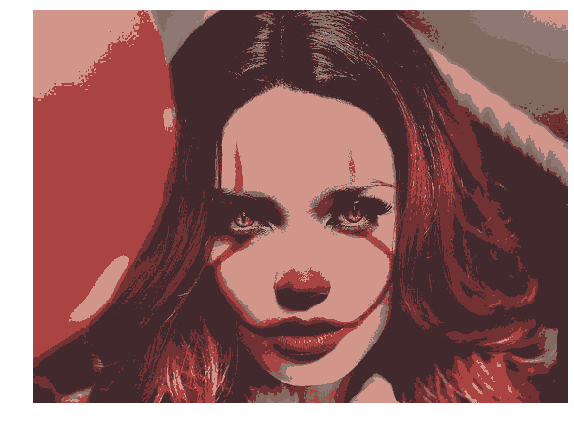

In [22]:
image = read_image("./image.png")
result = clusterize_image(image, col=6, init="sample")
show_image(result)
save_image(result, "result.jpg")

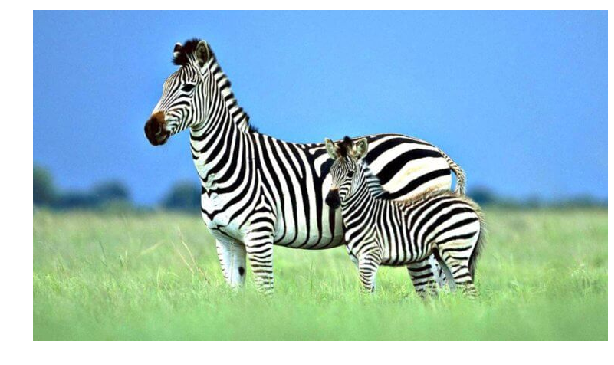

In [18]:
show_image(read_image("./zebra.png"))

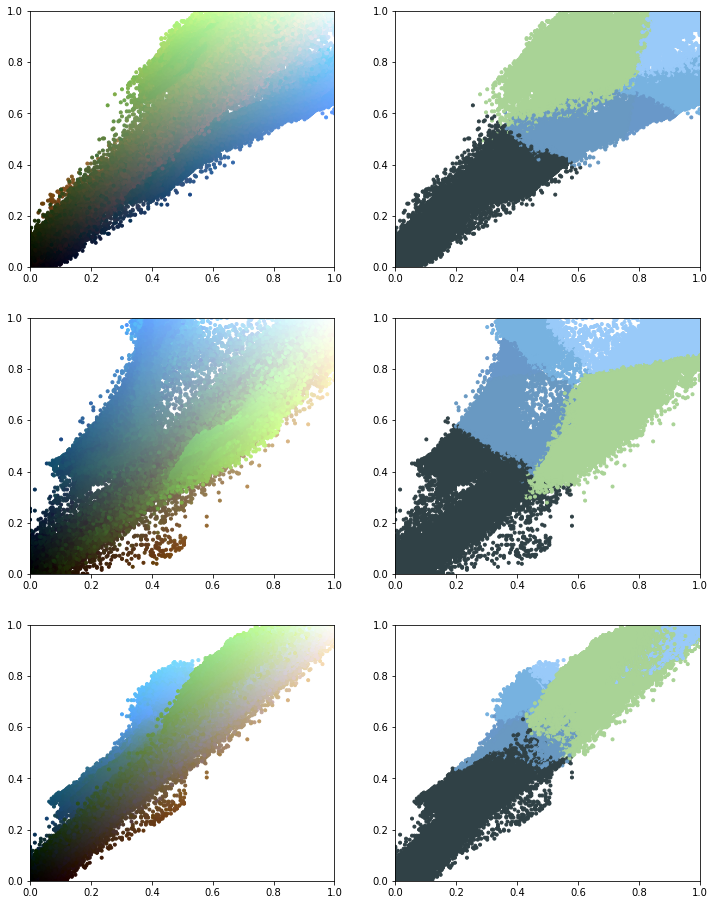

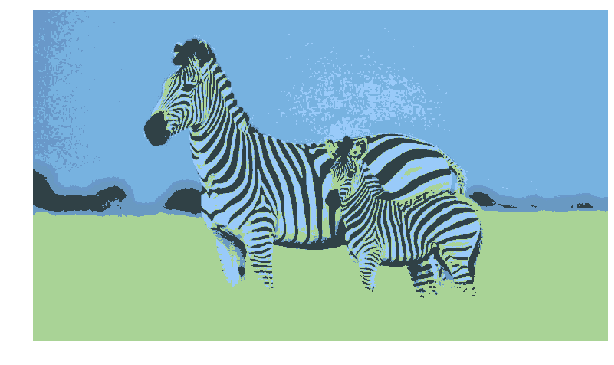

In [23]:
image2 = read_image("./zebra.png")
result2 = clusterize_image(image2, col=6, init="sample")
show_image(result2)
save_image(result2, "zebra_res.jpg")

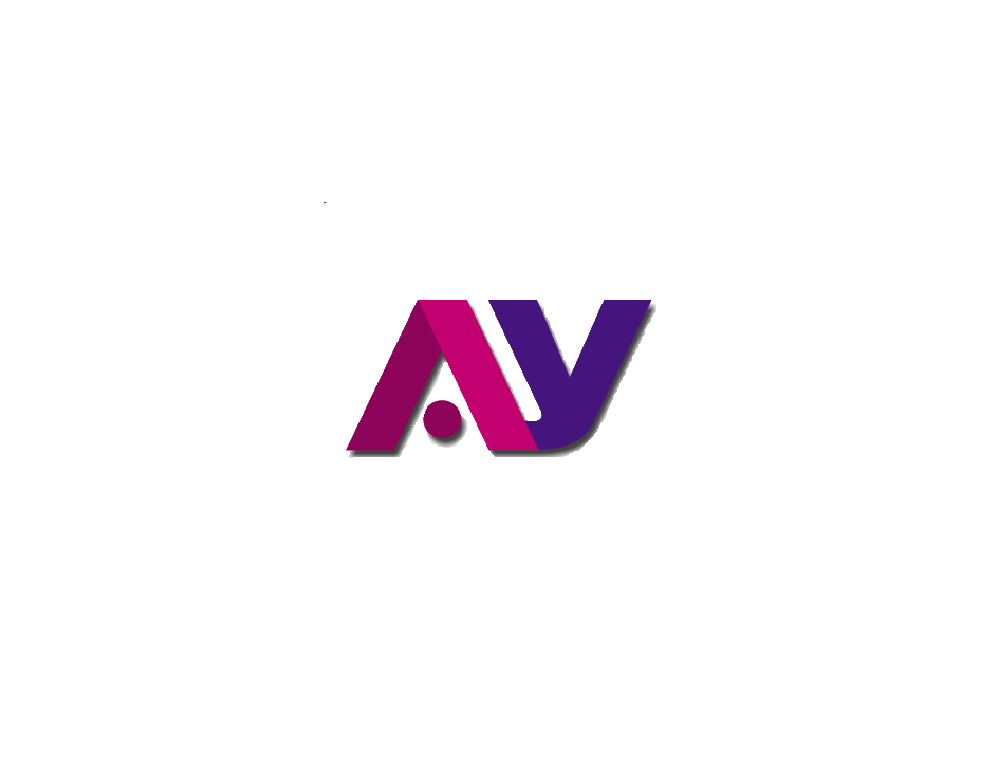

In [29]:
show_image(read_image("./real_au.png"))

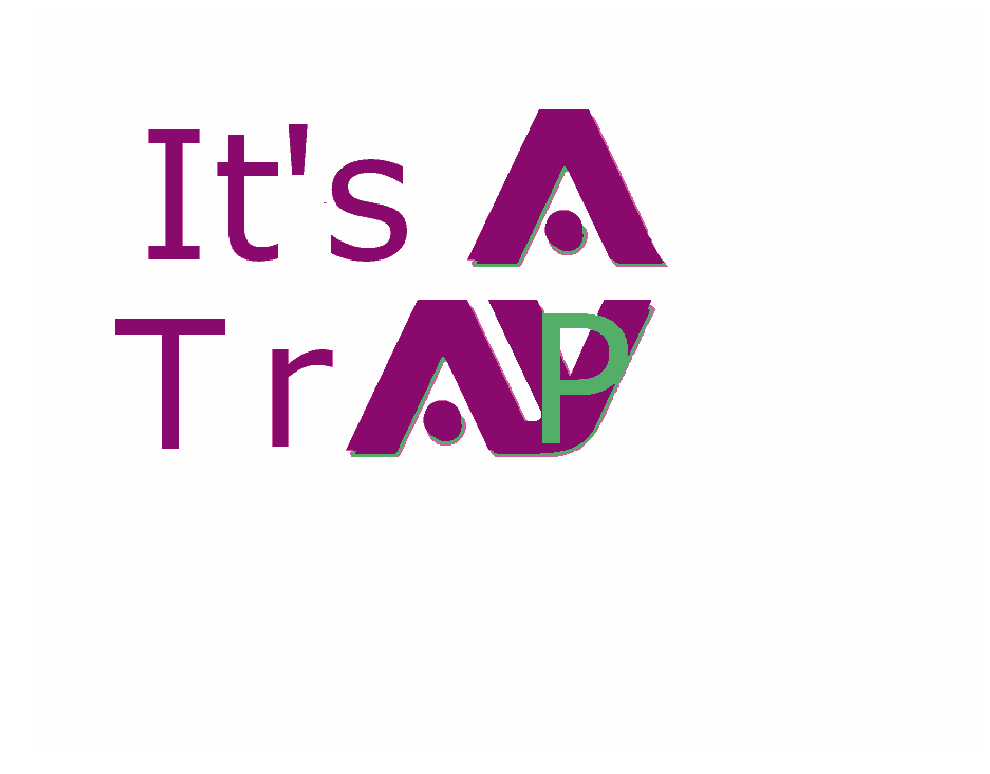

In [30]:
image3 = read_image("./real_au.png")
result3 = clusterize_image(image3, col=4, init="random")
show_image(result3)
save_image(result3, "realau_res.jpg")